In [1]:
import numpy as np
import math
import re
import matplotlib.pyplot as plt
%matplotlib inline

In [10]:
class PDE:
    def __init__(self, xi, tpoints=201, xpoints=512, trange=(0,20), xrange=(-30, 30), boundary='periodic', seed=0):
        """
        xi is a 2d matrix where each entry corresponds to a coefficient of a term, 
        where the 1st axis corresponds to the order of the space partial derivative
        and the 2nd axis corresponds to the degree of the function.
        For example, ut = 1+2u+3u**2 + 4ux+5uxu+6uxu**2 + 7uxx+8uxxu+9uxxu**2
        becomes [[1, 2, 3],[4, 5, 6],[7, 8, 9]]
        """
        
        self.rng = np.random.RandomState(seed)
        self.boundary = boundary
        
        self.xi = xi
        self.max_order = self.xi.shape[0]-1 #the minus 1 is because it goes from 0 to max, inclusive
        self.max_degree = self.xi.shape[1]-1 #the minus 1 is because it goes from 0 to max, inclusive
        
        self.tpoints = tpoints
        self.xpoints = xpoints
        self.trange = trange
        self.xrange = xrange
        
        self.dt = (self.trange[1]-self.trange[0])/ self.tpoints #time steps
        self.dx = (self.xrange[1]-self.xrange[0])/ self.xpoints #space step
        
        self.u = self.init_u()
        self.simulated = False
        
    def init_u(self):
        #makes one wavelength of cos, from 1 crest to the next
        xarr = np.linspace(self.xrange[0], self.xrange[1], self.xpoints, endpoint=False)
        k = 2*np.pi/(self.xrange[1] - self.xrange[0])
        phi = np.pi
        u0 = np.cos(k*xarr+phi)
        uempty = np.full((self.xpoints,), np.nan, dtype=float)
        return np.vstack([u0]+[uempty]*(self.tpoints-1))
    
    def __str__(self):
        string = 'ut ='
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                if coef == 0:
                    term = ''
                else:
                    #coefficient factor
                    if coef > 0:
                        term = ' + ' + str(coef)
                    elif coef < 0:
                        term = ' - ' + str(-coef)
                    #partial deriv factor
                    if order > 0:
                        term += 'u' + 'x'*order
                    else: 
                        pass
                    #function factor
                    if degree == 1:
                        term += 'u'
                    elif degree > 1:
                        term += 'u**'+degree
                    else: 
                        pass
                string += term
        if string == 'ut =':
            rep = 'ut = 0'
        return string
    def __repr__(self):
        rep = self.__str__()
        rep += '\n\twith xpoints='+str(self.xpoints)+' in '+str(self.xrange)
        rep += '\n\tand with tpoints='+str(self.tpoints)+' in '+str(self.trange)
        rep += '\n\twith '+str(self.boundary)+' boundary condition'
        return rep
        
        
    def get_du_x(self, time, point):
        ugrid = self.u[time]
        try:
            uright = ugrid[point+1]
        except IndexError:
            if boundary=='periodic':
                uright = ugrid[point+1-self.xpoints]
            else:
                raise
        try:
            uleft = ugrid[point]
        except IndexError:
            if boundary=='periodic':
                uleft = ugrid[point-self.xpoints]
            else:
                raise
        return uright - uleft
    def get_du_x_middle(self, time, point):
        ugrid = self.u[time]
        try:
            uright = ugrid[point+1]
        except IndexError:
            uright = ugrid[point+1-self.xpoints]
        try:
            uleft = ugrid[point-1]
        except IndexError:
            uleft = ugrid[point-1-self.xpoints]
        return uright - uleft
    
    def get_x_deriv_forward(self, time, point, order):
        if order == 0:
            return self.get_du_x(time, point)
        else:
            return (self.get_x_deriv(time, point+1, order-1)-self.get_x_deriv(time, point, order-1))/self.dx
    def get_x_deriv_backward(self, time, point, order):
        if order == 0:
            return self.get_du_x(time, point-1)
        else:
            return (self.get_x_deriv(time, point, order-1)-self.get_x_deriv(time, point-1, order-1))/self.dx
    def get_x_deriv_middle(self, time, point, order):
        if order == 0:
            return self.get_du_x_middle(time, point)/(2*self.dx)
        else: 
            return (self.get_x_deriv(time, point+1, order-1)-self.get_x_deriv(time, point-1, order-1))/(2*self.dx)
    def get_x_deriv(self, time, point, order):
        if order > 0:
            try:
                deriv = self.get_x_deriv_middle(time, point, order)
            except IndexError: #Only raised if not periodic
                try:
                    deriv = self.get_x_deriv_forward(time, point, order)
                except IndexError: #Only raised if not periodic
                    deriv = self.get_x_deriv_backward(time, point, order)
        elif order == 0:
            deriv = self.u[time, point]
        else:
            raise ValueError("Derivative order cannot be negative")
        return deriv
    def get_x_derivs_grid(self, time, deg=5, extra_fact=0.1):
        """
        deg controls the degree of the fitted polynomial
        extra_fact controls how much to look ahead and behind the defined interval, since the interval is periodic
        extra should not be more than half, 
            as that would make the fit take into account more than twice the number of points necessary
        """
        if extra_fact > 0:
            assert self.boundary == 'periodic', "Only periodic boundary condition" +\
                " can consider points ahead and behind when smoothing"
            assert extra_fact <= 0.5, "Extra should not be more than half the number of points"
            extra = int(self.xpoints*extra_fact)
            derivs = np.empty((self.max_order+1, self.xpoints))
            if self.max_order < 0:
                raise ValueError("Derivative order cannot be negative")
            else:
                derivs[0] = self.u[time]
                if self.max_order > 0:
                    #smoothing
                    #creating array of x values
                    rangesize = self.xrange[1]-self.xrange[0]
                    limleft = self.xrange[0]-rangesize
                    limright = self.xrange[1]+rangesize
                    xarrleft = np.linspace(limleft, self.xrange[0], self.xpoints, endpoint=False)
                    xarrmid = np.linspace(self.xrange[0], self.xrange[1], self.xpoints, endpoint=False)
                    xarrright = np.linspace(self.xrange[1], limright, self.xpoints, endpoint=False)
                    xarr = np.hstack([xarrleft[-extra:], xarrmid, xarrright[:extra]])
                    xarr = xarrmid[extra:-extra]
                    #creating array of u values
                    uarr = np.hstack([self.u[time, -extra:], self.u[time], self.u[time, :extra]])
                    uarr = self.u[time, extra:-extra]
                    #fitting polynomial
                    poly = np.polynomial.chebyshev.Chebyshev.fit(xarr, uarr, deg)
                    for order in range(1, self.max_order+1):
                        deriv = poly.deriv(order)
                        derivs[order] = deriv(xarrmid)
        return derivs
    def get_t_deriv(self, time, point):
        deriv = 0
        for order in range(0, self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                u = self.u[time, point]
                if order == 0:
                    xderiv = 1
                else:
                    xderiv = self.get_x_deriv(time, point, order)
                try: 
                    deriv += coef * u**degree * xderiv
                except FloatingPointError:
                    raise
        return deriv
    def get_t_deriv_grid(self, time):
        t_deriv_grid = np.zeros((self.xpoints,))
        for order in range(0, self.max_order+1):
            for degree in range(self.max_degree+1):
                coef = self.xi[order, degree]
                u_grid = self.u[time]
                x_derivs_grid = self.get_x_derivs_grid(time)
                if order == 0:
                    x_deriv_grid = np.ones((self.xpoints,))
                else:
                    x_deriv_grid = x_derivs_grid[order]
                try: t_deriv_grid += coef * u_grid**degree * x_deriv_grid
                except FloatingPointError:
                    raise
        return t_deriv_grid
    
    def sim_next_point(self, time, point):
        u_curr = self.u[time, point]
        for order in range(self.max_order+1):
            for degree in range(self.max_degree+1):
                u_next = u_curr + self.dt*self.get_t_deriv(time, point)

        return u_next
    def sim_next_grid(self, time):
        return self.u[time] + self.get_t_deriv_grid(time) * self.dt
    def sim(self, force=False):
        if self.simulated == False or force == True:
            if force == True: print("Resimulating PDE from initial conditions")
            for time in range(self.tpoints-1):
                self.u[time+1] = self.sim_next_grid(time)
            self.simulated == True
            return self.u
        else:
            print("PDE already simulated")
            return self.u

In [11]:
xi = np.zeros((4, 2))
xi[3,0] = -1
xi[1,1] = 6
pde = PDE(xi, xrange=(-np.pi, np.pi))
pde

ut = + 6.0uxu - 1.0uxxx
	with xpoints=512 in (-3.141592653589793, 3.141592653589793)
	and with tpoints=201 in (0, 20)
	with periodic boundary condition

C:\Users\Main User\AppData\Local\conda\conda\envs\keras\lib\site-packages\ipykernel\__main__.py:196: RuntimeWarning: overflow encountered in multiply
C:\Users\Main User\AppData\Local\conda\conda\envs\keras\lib\site-packages\ipykernel\__main__.py:118: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Main User\AppData\Local\conda\conda\envs\keras\lib\site-packages\ipykernel\__main__.py:113: RuntimeWarning: invalid value encountered in double_scalars
C:\Users\Main User\AppData\Local\conda\conda\envs\keras\lib\site-packages\ipykernel\__main__.py:196: RuntimeWarning: invalid value encountered in multiply


ValueError: On entry to DGELSD parameter number 6 had an illegal value

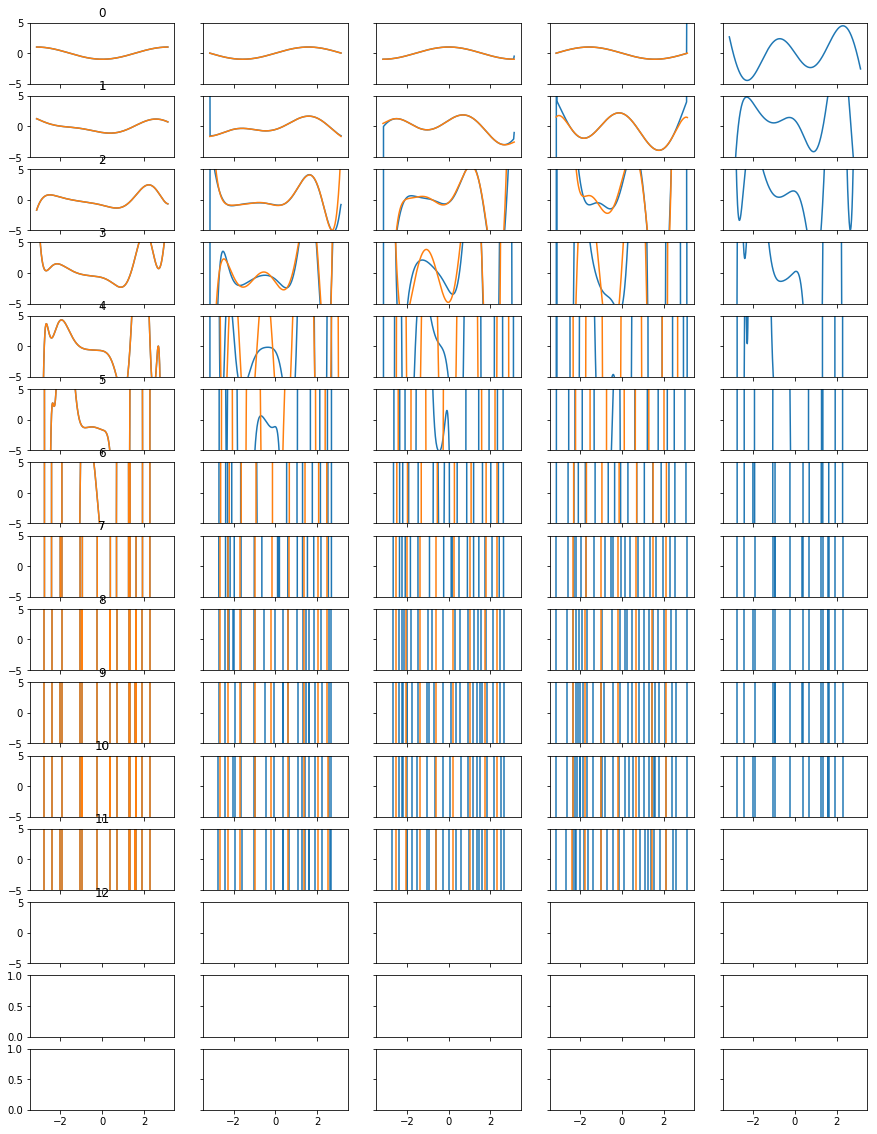

In [15]:
max_time = 14 #or pde.tpoints
jump_fact = 1

fig, axes = plt.subplots(nrows=max_time//jump_fact+1, ncols=1+pde.max_order+1, figsize=(15,20), sharex=True, sharey='row')
x = np.linspace(pde.xrange[0], pde.xrange[1], pde.xpoints)

for time in range(max_time):
    if time % jump_fact == 0:
        smooth_derivs = pde.get_x_derivs_grid(time, deg=10, extra_fact=0.05)
        for order in range(0, pde.max_order+1):
            yi_1 = [pde.get_x_deriv(time, point, order) for point in range(pde.xpoints)]
            yi_2 = smooth_derivs[order]
            axes[time//jump_fact, order].plot(x, yi_1)
            axes[time//jump_fact, order].plot(x, yi_2)
        yn = pde.get_t_deriv_grid(time)
        axes[time//jump_fact, -1].plot(x, yn)
        axes[time//jump_fact, 0].set_title(str(time))
        
        
    ylim = axes[time//jump_fact, 0].get_ylim()
    axes[time//jump_fact, -1].set_ylim(-5, 5)
        
    if time != max_time-1:
        pde.u[time+1] = pde.sim_next_grid(time)
    
plt.subplots_adjust(hspace=0.6)
plt.show()

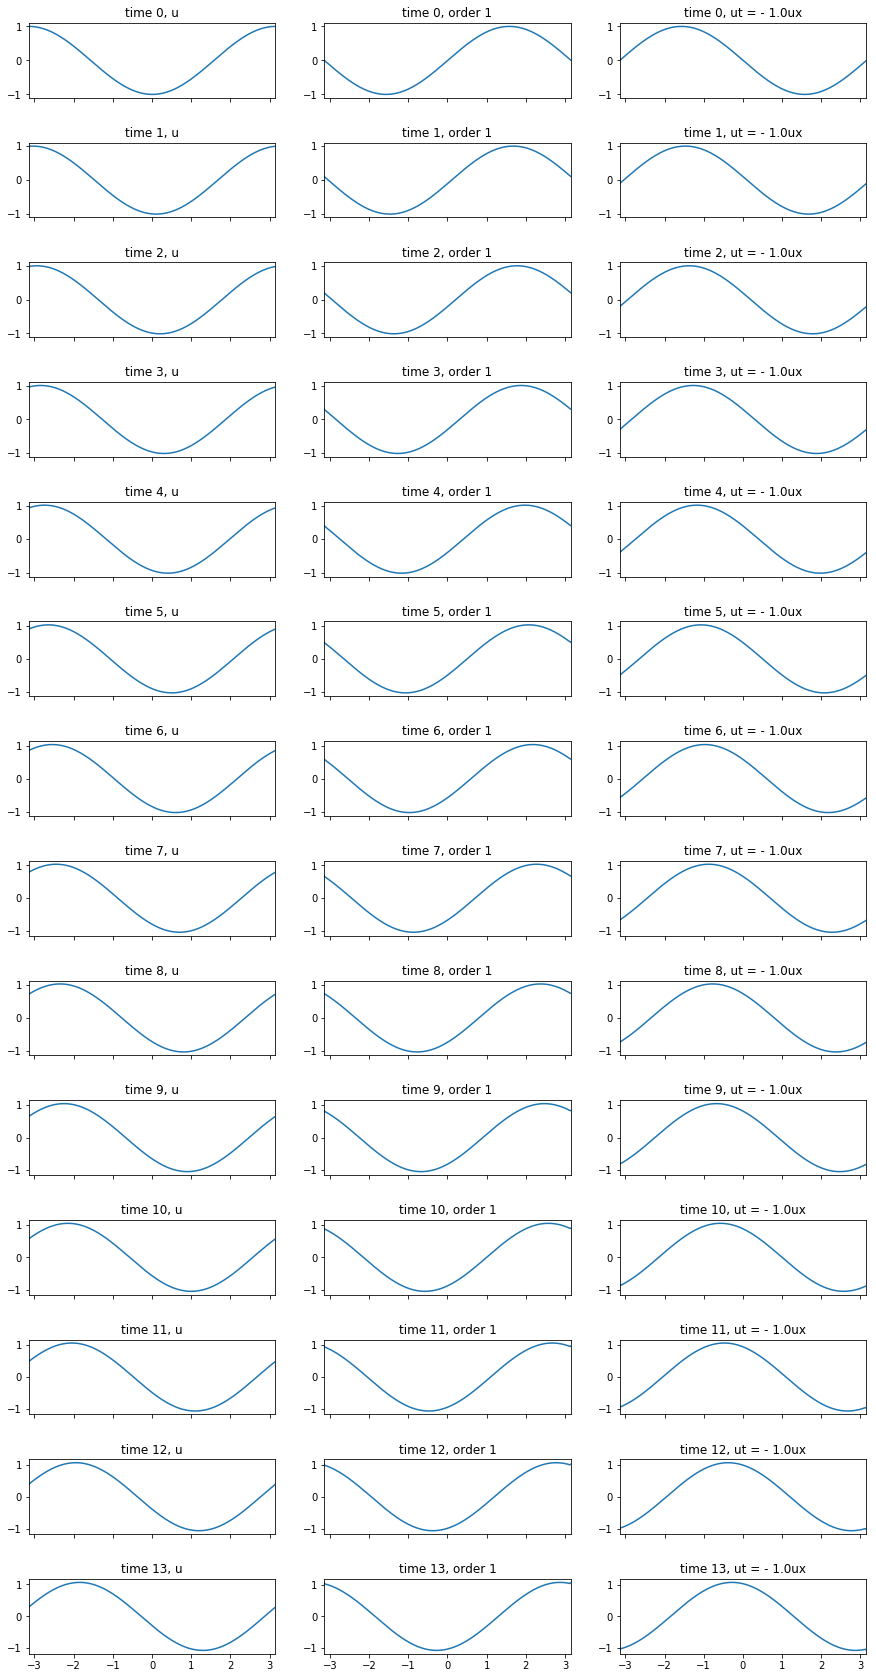

In [92]:
max_time = 14
lim_disc = 0
plot_order = 1
jump_fact = 1

fig, axes = plt.subplots(nrows=max_time//jump_fact, ncols=plot_order+2, figsize=(15,30), sharex='all', sharey='none')
x = np.linspace(pde.xrange[0], pde.xrange[1], pde.xpoints)

for time in range(max_time):
    #plot
    if time%jump_fact == 0: 
        #function
        yu = list(pde.u[time])
        axes[time//jump_fact, 0].plot(x, yu)
        axes[time//jump_fact, 0].set(title='time '+str(time)+', u')
        #xderivs
        for order in range(1, plot_order+1):
            yx = [pde.get_x_deriv(time, point, order) for point in range(pde.xpoints)]
            axes[time//jump_fact, order].plot(x, yx)
            axes[time//jump_fact, order].set(title='time '+str(time)+', order '+str(order))
        #tderiv
        yt = [pde.get_t_deriv(time, point) for point in range(pde.xpoints)]
        axes[time//jump_fact, -1].plot(x, yt)
        axes[time//jump_fact, -1].set(title='time '+str(time)+', '+str(pde))
        #scaling
        #ymin = np.min(y[int(pde.xpoints*lim_disc):int(pde.xpoints*(1-lim_disc))])
        #ymax = np.max(y[int(pde.xpoints*lim_disc):int(pde.xpoints*(1-lim_disc))])
        axes[time//jump_fact, 0].set_xlim(pde.xrange[0], pde.xrange[1])
        #axes[time//jump_fact, 0].set_ylim(ymin, ymax)
    
    #simulating
    pde.u[time+1] = pde.sim_next_grid(time)
    
plt.subplots_adjust(hspace=0.6)
plt.show()

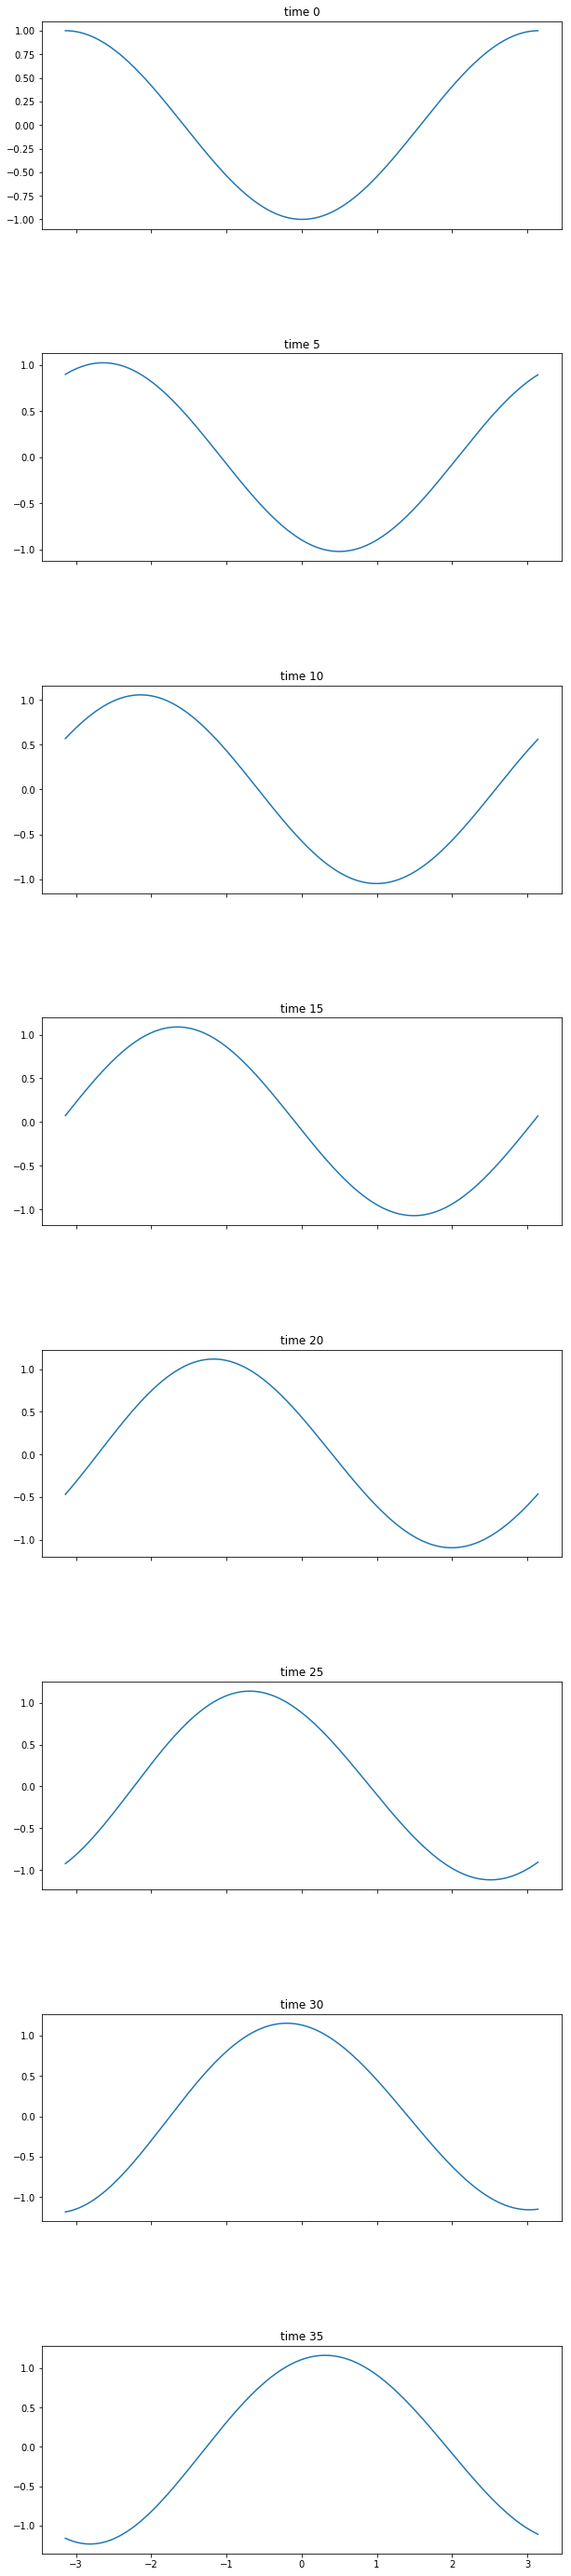

In [125]:
np.seterr(all='raise')
np.seterr(under='ignore')

max_time = 40
jump_fact = 5

fig, axes = plt.subplots(nrows=max_time//jump_fact, figsize=(10,50), sharex=True, sharey=False)
x = np.linspace(pde.xrange[0], pde.xrange[1], pde.xpoints)

for time in range(max_time):
    #print(str(time)+": u = "+str(pde.u[time, 0]))
    if time % jump_fact == 0:
        y = pde.u[time]
        axes[time//jump_fact].plot(x, y)
        axes[time//jump_fact].set(title='time '+str(time))
    pde.u[time+1] = pde.sim_next_grid(time)
axes[0].set_ylim(-1.1, 1.1)
    
plt.subplots_adjust(hspace=0.6)
plt.show()

### To Do
- separate boundary conditions
- make derivative functions have *optional* smoothing
- rewrite get_x_deriv and it's forward/backward/middle versions to have less nested steps
- expand possible equations to include more non-linearity, like ut = sin(ux)
- make it possible to have an irregular grid spacing
- add other boundary conditions
- check why harmonic oscillator doesn't conserve energy

### Notes
- Polynomial smoothing does not need to discard endpoints due to the periodic boundary conditions